In [11]:
import numpy as np
import pandas as pd
import SolveLinSys
import matplotlib.pyplot as plt
from numba import njit

import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
from scipy.interpolate import interp2d
from solver_2d import false_transient_one_iteration_python

In [12]:
@njit
def compute_derivatives(data, dim, order, dlt):
    res = np.zeros_like(data)
    if order == 1:                    # first order derivatives
        if dim == 0:                  # to first dimension
            res[1:,:] = (1 / dlt) * (data[1:,:] - data[:-1,:])
            res[0,:] = (1 / dlt) * (data[1,:] - data[0,:])
        elif dim == 1:                # to second dimension
            res[:,1:] = (1 / dlt) * (data[:,1:] - data[:,:-1])
            res[:,0] = (1 / dlt) * (data[:,1] - data[:,0])        
    elif order == 2:
        if dim == 0:                  # to first dimension
            res[1:-1,:] = (1 / dlt ** 2) * (data[2:,:] + data[:-2,:] - 2 * data[1:-1,:])
            res[-1,:] = (1 / dlt ** 2) * (data[-1,:] + data[-3,:] - 2 * data[-2,:])
            res[0,:] = (1 / dlt ** 2) * (data[2,:] + data[0,:] - 2 * data[1,:])
        elif dim == 1:                # to second dimension
            res[:,1:-1] = (1 / dlt ** 2) * (data[:,2:] + data[:,:-2] - 2 * data[:,1:-1])
            res[:,-1] = (1 / dlt ** 2) * (data[:,-1] + data[:,-3] - 2 * data[:,-2])
            res[:,0] = (1 / dlt ** 2) * (data[:,2] + data[:,0] - 2 * data[:,1])    
    return res

def false_transient_one_iteration(stateSpace, A, B1, B2, C1, C2, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B1.reshape(-1, 1, order='F'), B2.reshape(-1, 1, order='F')])
    C = np.hstack([C1.reshape(-1, 1, order='F'), C2.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out

PDE:
\begin{align*}
0 = \max_{\mathcal{E}}  &  -\delta \phi(y_1, y_2) + \eta \log \mathcal{E} \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} (-\lambda y_2 + \lambda \sum_{i=1}^m \pi^p_i \theta_i \mathcal{E})\\
&+ \frac{\eta-1}{\delta}\left[\gamma_1 + \gamma_2 y_1 + \gamma_2^+\boldsymbol{1}_{y_1\geq \bar{y}_1}(y_1-\bar{y}_1)\right]y_2\\
&+ \xi_a\sum_{i=1}^{n} \pi_i^c(\log \pi_i^c - \log \hat{\pi}_i^c)
\end{align*}

FOC of $\mathcal{E}$ gives:
$$
\mathcal{E} = -\frac{\eta}{\frac{\partial \phi}{\partial y_2} \lambda \sum_{i=1}^m \pi^d_i \theta_i}
$$

In [13]:
def false_transient(y1_grid, y2_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000, print_all=True):
    η, δ, θ, γ_1, γ_2, γ_2p, y_bar, πc_o, ξ_a = model_paras
    dy1 = y1_grid[1] - y1_grid[0]
    dy2 = y2_grid[1] - y2_grid[0]
    (y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
    stateSpace = np.hstack([y1_mat.reshape(-1, 1, order='F'), y2_mat.reshape(-1, 1, order='F')])    

    if v0 is None:
        v0 = -η*(y1_mat+y2_mat+(y1_mat+y2_mat)**2)

    d_Λ = γ_1 + γ_2*y1_mat + γ_2p*(y1_mat>y_bar)*(y1_mat-y_bar)

    πc = np.ones((len(πc_o), len(y1_grid), len(y2_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape    

    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()

        v0_dy1 = compute_derivatives(v0, 0, 1, dy1)
        v0_dy2 = compute_derivatives(v0, 1, 1, dy2)        

        e_tilde = -η/(v0_dy2*λ*np.sum(πc_o*θ, axis=0))
        e_tilde[e_tilde<=0] = 1e-15

        log_πc_ratio = -v0_dy2*λ*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

        A = np.ones_like(y1_mat) * (-δ)
        B1 = y2_mat
        B2 = λ*(-y2_mat+np.sum(πc_o*θ, axis=0)*e_tilde)
        C1 = np.zeros_like(y1_mat)
        C2 = np.zeros_like(y2_mat)
        D = η*np.log(e_tilde) + (η-1)/δ*d_Λ*y2_mat + ξ_a * c_entropy

        res = false_transient_one_iteration(stateSpace, A, B1, B2, C1, C2, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B1*v0_dy1 + B2*v0_dy2 + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    res = {'v0': v0,
           'e_tilde': e_tilde}
    return res

In [14]:
ξ_a = 1./100
ξ_p = 5.

λ = .116 # half life = 6 years 

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = np.array([0, .0197*2, .3853*2])
πd_o = np.array([1./3, 1./3, 1./3])

y1_step = .04
y1_grid_long = np.arange(0., 4., y1_step)
y1_grid_short = np.arange(0., 2.+y1_step, y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

ϕ_i = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, γ_1, γ_2, γ_2p_i, y_bar, πc_o, ξ_a)
    model_res = false_transient(y1_grid_long, y2_grid, model_paras,
                                v0=None, ϵ=.5, tol=1e-5, max_iter=2000, print_all=True)
    ϕ_i.append(model_res['v0'])

Iteration 1: LHS Error: 0.15001103705232136; RHS Error 0.24014706051372026
Iteration 2: LHS Error: 0.1765484409681989; RHS Error 0.18173146728802564
Iteration 3: LHS Error: 0.16760914649698663; RHS Error 0.18789896267573666
Iteration 4: LHS Error: 0.22811043910937767; RHS Error 0.28823377745270246
Iteration 5: LHS Error: 0.8703177468580319; RHS Error 1.1318129152573906
Iteration 6: LHS Error: 0.8622812967406603; RHS Error 1.4630871938824388
Iteration 7: LHS Error: 1.2091579673588133; RHS Error 3.3323324106842236
Iteration 8: LHS Error: 1.565086450708693; RHS Error 4.172643432463082
Iteration 9: LHS Error: 1.7089997902759295; RHS Error 4.4827255108238875
Iteration 10: LHS Error: 1.0460121178122066; RHS Error 3.184942303434747
Iteration 11: LHS Error: 1.0004820605445937; RHS Error 3.1311465144150663
Iteration 12: LHS Error: 1.0248524739671936; RHS Error 3.6246277350525187
Iteration 13: LHS Error: 0.9133348271393913; RHS Error 2.5779872112300684
Iteration 14: LHS Error: 0.698101285586588;

Iteration 110: LHS Error: 0.03561706032788692; RHS Error 0.035772515789499346
Iteration 111: LHS Error: 0.035339100381653665; RHS Error 0.035492984257457075
Iteration 112: LHS Error: 0.03506431960609646; RHS Error 0.03521665266268745
Iteration 113: LHS Error: 0.03479267605387726; RHS Error 0.03494347892923626
Iteration 114: LHS Error: 0.034524127564034224; RHS Error 0.03467342139318172
Iteration 115: LHS Error: 0.034258632193528094; RHS Error 0.03440643842399016
Iteration 116: LHS Error: 0.03399614790797134; RHS Error 0.03414248837239135
Iteration 117: LHS Error: 0.03373663251722547; RHS Error 0.03388152955906379
Iteration 118: LHS Error: 0.033480043632422074; RHS Error 0.033623520145747626
Iteration 119: LHS Error: 0.03322633866226443; RHS Error 0.033368418091770616
Iteration 120: LHS Error: 0.03297547483194574; RHS Error 0.03311618115053591
Iteration 121: LHS Error: 0.03272740934271923; RHS Error 0.0328667668878771
Iteration 122: LHS Error: 0.03248209899308918; RHS Error 0.0326201327

Iteration 217: LHS Error: 0.01713108377946959; RHS Error 0.01721858691138979
Iteration 218: LHS Error: 0.017023573729941788; RHS Error 0.017110891351520552
Iteration 219: LHS Error: 0.0169168331339975; RHS Error 0.01700396780620428
Iteration 220: LHS Error: 0.016810855128870372; RHS Error 0.016897809373207826
Iteration 221: LHS Error: 0.01670563293064653; RHS Error 0.01679240923015922
Iteration 222: LHS Error: 0.016601159832914547; RHS Error 0.016687760633146947
Iteration 223: LHS Error: 0.01649742920533548; RHS Error 0.016583856915163203
Iteration 224: LHS Error: 0.016394434492497112; RHS Error 0.016480691484898627
Iteration 225: LHS Error: 0.01629216921272736; RHS Error 0.016378257825522505
Iteration 226: LHS Error: 0.016190626957115484; RHS Error 0.016276549493455125
Iteration 227: LHS Error: 0.01608980138847471; RHS Error 0.016175560117412488
Iteration 228: LHS Error: 0.015989686240551748; RHS Error 0.01607528339749241
Iteration 229: LHS Error: 0.015890275317172353; RHS Error 0.015

Iteration 325: LHS Error: 0.008899501645736052; RHS Error 0.0089758222875609
Iteration 326: LHS Error: 0.008847514218450314; RHS Error 0.008923773258359441
Iteration 327: LHS Error: 0.00879586568040125; RHS Error 0.008872063146755121
Iteration 328: LHS Error: 0.00874455283523723; RHS Error 0.008820688987122197
Iteration 329: LHS Error: 0.008693574148587402; RHS Error 0.008769649739572866
Iteration 330: LHS Error: 0.008642927321799831; RHS Error 0.008718942797944024
Iteration 331: LHS Error: 0.008592610102079234; RHS Error 0.00866856587831899
Iteration 332: LHS Error: 0.008542620250594268; RHS Error 0.008618516741260532
Iteration 333: LHS Error: 0.008492955542225289; RHS Error 0.008568793160941765
Iteration 334: LHS Error: 0.008443613765127367; RHS Error 0.008519392924949423
Iteration 335: LHS Error: 0.00839459271884202; RHS Error 0.008470313833995671
Iteration 336: LHS Error: 0.008345890212497764; RHS Error 0.00842155369986522
Iteration 337: LHS Error: 0.008297504063643046; RHS Error 0

Iteration 432: LHS Error: 0.004851509454788072; RHS Error 0.004923946362762874
Iteration 433: LHS Error: 0.004824709606333855; RHS Error 0.004897132842057658
Iteration 434: LHS Error: 0.0047980630982760175; RHS Error 0.004870472880662682
Iteration 435: LHS Error: 0.004771568905653112; RHS Error 0.004843965448013923
Iteration 436: LHS Error: 0.0047452260147586856; RHS Error 0.004817609524968333
Iteration 437: LHS Error: 0.0047190334228979225; RHS Error 0.0047914041034261
Iteration 438: LHS Error: 0.004692990138201125; RHS Error 0.004765348186258525
Iteration 439: LHS Error: 0.004667095179556213; RHS Error 0.004739440787211585
Iteration 440: LHS Error: 0.004641347576248123; RHS Error 0.004713680930463551
Iteration 441: LHS Error: 0.00461574636801565; RHS Error 0.004688067650812824
Iteration 442: LHS Error: 0.004590290604685521; RHS Error 0.004662599993205355
Iteration 443: LHS Error: 0.004564979346140419; RHS Error 0.004637277012810206
Iteration 444: LHS Error: 0.004539811662125359; RHS 

Iteration 540: LHS Error: 0.0026775088484018994; RHS Error 0.0027490812504577244
Iteration 541: LHS Error: 0.0026628842405003184; RHS Error 0.002734451570659005
Iteration 542: LHS Error: 0.0026483406577746393; RHS Error 0.0027199029490163756
Iteration 543: LHS Error: 0.002633877643697602; RHS Error 0.0027054349291946167
Iteration 544: LHS Error: 0.002619494744118711; RHS Error 0.0026910470571343686
Iteration 545: LHS Error: 0.0026051915073104226; RHS Error 0.002676738881047497
Iteration 546: LHS Error: 0.002590967484048079; RHS Error 0.0026625099515605183
Iteration 547: LHS Error: 0.002576822227730702; RHS Error 0.0026483598219001064
Iteration 548: LHS Error: 0.0025627552943099374; RHS Error 0.002634288047808714
Iteration 549: LHS Error: 0.002548766242300715; RHS Error 0.0026202941875895225
Iteration 550: LHS Error: 0.0025348546328185506; RHS Error 0.002606377802110496
Iteration 551: LHS Error: 0.0025210200295120444; RHS Error 0.0025925384547741126
Iteration 552: LHS Error: 0.002507261

Iteration 648: LHS Error: 0.001485336984087482; RHS Error 0.0015565233970732534
Iteration 649: LHS Error: 0.001477282018688797; RHS Error 0.00154846604946475
Iteration 650: LHS Error: 0.0014692711445345452; RHS Error 0.0015404528078160895
Iteration 651: LHS Error: 0.001461304117851725; RHS Error 0.0015324834281076616
Iteration 652: LHS Error: 0.0014533806962528928; RHS Error 0.0015245576676928413
Iteration 653: LHS Error: 0.0014455006389244573; RHS Error 0.0015166752855420296
Iteration 654: LHS Error: 0.00143766370652898; RHS Error 0.0015088360420610347
Iteration 655: LHS Error: 0.0014298696611856343; RHS Error 0.0015010396991583103
Iteration 656: LHS Error: 0.0014221182664666543; RHS Error 0.0014932860201769538
Iteration 657: LHS Error: 0.0014144092874062153; RHS Error 0.0014855747699751704
Iteration 658: LHS Error: 0.001406742490418722; RHS Error 0.001477905714767469
Iteration 659: LHS Error: 0.0013991176433290065; RHS Error 0.00147027862219469
Iteration 660: LHS Error: 0.00139153451

Iteration 756: LHS Error: 0.0008271041348848485; RHS Error 0.0008980954008191849
Iteration 757: LHS Error: 0.0008226485918498838; RHS Error 0.0008936385396336177
Iteration 758: LHS Error: 0.0008182173700657103; RHS Error 0.0008892060076742259
Iteration 759: LHS Error: 0.000813810335181131; RHS Error 0.0008847976706105876
Iteration 760: LHS Error: 0.0008094273535323993; RHS Error 0.0008804133947759862
Iteration 761: LHS Error: 0.0008050682921290075; RHS Error 0.0008760530471998429
Iteration 762: LHS Error: 0.0008007330186536876; RHS Error 0.0008717164955864831
Iteration 763: LHS Error: 0.0007964214015316884; RHS Error 0.0008674036083579639
Iteration 764: LHS Error: 0.0007921333098739325; RHS Error 0.0008631142546109832
Iteration 765: LHS Error: 0.0007878686134770163; RHS Error 0.0008588483040999489
Iteration 766: LHS Error: 0.0007836271828907115; RHS Error 0.0008546056273564528
Iteration 767: LHS Error: 0.000779408889377109; RHS Error 0.0008503860956081133
Iteration 768: LHS Error: 0.00

Iteration 863: LHS Error: 0.000465051206475664; RHS Error 0.0005359400580362689
Iteration 864: LHS Error: 0.00046256476305117644; RHS Error 0.0005334529468434823
Iteration 865: LHS Error: 0.00046009178111461324; RHS Error 0.0005309793013854591
Iteration 866: LHS Error: 0.0004576321868228206; RHS Error 0.0005285190477812146
Iteration 867: LHS Error: 0.0004551859066488362; RHS Error 0.0005260721124834555
Iteration 868: LHS Error: 0.0004527528675488668; RHS Error 0.0005236384224284879
Iteration 869: LHS Error: 0.0004503329968432723; RHS Error 0.0005212179049241539
Iteration 870: LHS Error: 0.00044792622231959456; RHS Error 0.0005188104876945182
Iteration 871: LHS Error: 0.0004455324720673559; RHS Error 0.0005164160988203881
Iteration 872: LHS Error: 0.00044315167468944594; RHS Error 0.000514034666872415
Iteration 873: LHS Error: 0.00044078375909073486; RHS Error 0.0005116661207317796
Iteration 874: LHS Error: 0.000438428654639722; RHS Error 0.0005093103897440276
Iteration 875: LHS Error: 

Iteration 971: LHS Error: 0.0002611827809122502; RHS Error 0.0003320197748061249
Iteration 972: LHS Error: 0.00025979620507143864; RHS Error 0.0003306328595933661
Iteration 973: LHS Error: 0.00025841707799223457; RHS Error 0.00032925339519809804
Iteration 974: LHS Error: 0.00025704535923232186; RHS Error 0.0003278813411849296
Iteration 975: LHS Error: 0.0002556810085163619; RHS Error 0.0003265166572989364
Iteration 976: LHS Error: 0.0002543239857999424; RHS Error 0.00032515930350704436
Iteration 977: LHS Error: 0.00025297425121451056; RHS Error 0.0003238092399123621
Iteration 978: LHS Error: 0.00025163176507803087; RHS Error 0.0003224664268697691
Iteration 979: LHS Error: 0.00025029648796248694; RHS Error 0.0003211308249395778
Iteration 980: LHS Error: 0.0002489683805819709; RHS Error 0.00031980239481482764
Iteration 981: LHS Error: 0.0002476474039223575; RHS Error 0.00031848109750449993
Iteration 982: LHS Error: 0.0002463335191453808; RHS Error 0.0003171668941420319
Iteration 983: LHS

Iteration 1078: LHS Error: 0.00014804776462185032; RHS Error 0.00021885784333074143
Iteration 1079: LHS Error: 0.00014726693928324153; RHS Error 0.00021807684805161265
Iteration 1080: LHS Error: 0.0001464902779382271; RHS Error 0.00021730001782112318
Iteration 1081: LHS Error: 0.00014571775809812948; RHS Error 0.00021652733018256987
Iteration 1082: LHS Error: 0.0001449496194414479; RHS Error 0.00021575876168647423
Iteration 1083: LHS Error: 0.00014418531589299732; RHS Error 0.00021499419341307335
Iteration 1084: LHS Error: 0.00014342508848308455; RHS Error 0.00021423380548238335
Iteration 1085: LHS Error: 0.00014266890418213052; RHS Error 0.00021347747077557488
Iteration 1086: LHS Error: 0.0001419167401373045; RHS Error 0.00021272515806280978
Iteration 1087: LHS Error: 0.00014116857548529538; RHS Error 0.00021197684483965917
Iteration 1088: LHS Error: 0.00014042439191186418; RHS Error 0.00021123251061068438
Iteration 1089: LHS Error: 0.000139684172472343; RHS Error 0.000210492136977505

Iteration 1186: LHS Error: 8.377872578435586e-05; RHS Error 0.00016367087667386315
Iteration 1187: LHS Error: 8.333956379047436e-05; RHS Error 0.0001641060247196402
Iteration 1188: LHS Error: 8.290272793054498e-05; RHS Error 0.00016453887233222608
Iteration 1189: LHS Error: 8.246820578250436e-05; RHS Error 0.00016496943181393275
Iteration 1190: LHS Error: 8.203598497580344e-05; RHS Error 0.00016539771540709236
Iteration 1191: LHS Error: 8.160605321805292e-05; RHS Error 0.00016582373527908312
Iteration 1192: LHS Error: 8.117839824883788e-05; RHS Error 0.00016624750351444673
Iteration 1193: LHS Error: 8.07530078823504e-05; RHS Error 0.00016666903212926576
Iteration 1194: LHS Error: 8.0329869964757e-05; RHS Error 0.00016708833304807102
Iteration 1195: LHS Error: 7.9908972431042e-05; RHS Error 0.00016750541818856546
Iteration 1196: LHS Error: 7.949030326592776e-05; RHS Error 0.0001679202993448009
Iteration 1197: LHS Error: 7.907385052163818e-05; RHS Error 0.00016833298824532605
Iteration 1

Iteration 1294: LHS Error: 4.7569309941764004e-05; RHS Error 0.00019956551032186687
Iteration 1295: LHS Error: 4.732155526632198e-05; RHS Error 0.0001998114232334841
Iteration 1296: LHS Error: 4.707501904910316e-05; RHS Error 0.00020005601270772777
Iteration 1297: LHS Error: 4.682963771962534e-05; RHS Error 0.000200299330165285
Iteration 1298: LHS Error: 4.658552217762235e-05; RHS Error 0.00020054138339219152
Iteration 1299: LHS Error: 4.634270339032298e-05; RHS Error 0.00020078217419358668
Iteration 1300: LHS Error: 4.610118308612243e-05; RHS Error 0.00020102170399573238
Iteration 1301: LHS Error: 4.586095120906464e-05; RHS Error 0.00020125997553295527
Iteration 1302: LHS Error: 4.5621994440026015e-05; RHS Error 0.00020149699318591785
Iteration 1303: LHS Error: 4.538430033740326e-05; RHS Error 0.00020173276271683027
Iteration 1304: LHS Error: 4.51478586356302e-05; RHS Error 0.00020196729085576737
Iteration 1305: LHS Error: 4.491266103556768e-05; RHS Error 0.00020220058489037185
Iterat

Iteration 1402: LHS Error: 2.70932663362089e-05; RHS Error 0.0002198825856148251
Iteration 1403: LHS Error: 2.6952788024559027e-05; RHS Error 0.00022002204654573976
Iteration 1404: LHS Error: 2.681304398777229e-05; RHS Error 0.00022016077943257106
Iteration 1405: LHS Error: 2.6674030298323714e-05; RHS Error 0.00022029878814203152
Iteration 1406: LHS Error: 2.6535743117506172e-05; RHS Error 0.00022043607649123442
Iteration 1407: LHS Error: 2.6398178617270673e-05; RHS Error 0.0002205726482936432
Iteration 1408: LHS Error: 2.6261333017529864e-05; RHS Error 0.0002207085073204218
Iteration 1409: LHS Error: 2.612520254352546e-05; RHS Error 0.00022084365733673894
Iteration 1410: LHS Error: 2.5989783463131744e-05; RHS Error 0.0002209781020948154
Iteration 1411: LHS Error: 2.585507205132842e-05; RHS Error 0.000221111845294511
Iteration 1412: LHS Error: 2.5721064639938618e-05; RHS Error 0.00022124489063328479
Iteration 1413: LHS Error: 2.558775751104747e-05; RHS Error 0.0002213772417912485
Itera

Iteration 1510: LHS Error: 1.5473615764705073e-05; RHS Error 0.00023142236026055252
Iteration 1511: LHS Error: 1.5393744265068676e-05; RHS Error 0.00023150168238163238
Iteration 1512: LHS Error: 1.531429989753974e-05; RHS Error 0.0002315805958618411
Iteration 1513: LHS Error: 1.5235275908409562e-05; RHS Error 0.00023165910500812237
Iteration 1514: LHS Error: 1.5156665325477547e-05; RHS Error 0.00023173721221596277
Iteration 1515: LHS Error: 1.5078462352491329e-05; RHS Error 0.00023181491871161752
Iteration 1516: LHS Error: 1.5000662807906906e-05; RHS Error 0.0002318922251800387
Iteration 1517: LHS Error: 1.4923264048505303e-05; RHS Error 0.0002319691321688161
Iteration 1518: LHS Error: 1.4846264503987072e-05; RHS Error 0.00023204564040418818
Iteration 1519: LHS Error: 1.476966316538153e-05; RHS Error 0.00023212175092936216
Iteration 1520: LHS Error: 1.4693459101877693e-05; RHS Error 0.00023219746515189266
Iteration 1521: LHS Error: 1.4617651151738187e-05; RHS Error 0.000232272784838269

Iteration 17: LHS Error: 0.1760098145411222; RHS Error 0.18459508992127405
Iteration 18: LHS Error: 0.16695859280004033; RHS Error 0.17515036251007235
Iteration 19: LHS Error: 0.1583394228403172; RHS Error 0.1661463364496782
Iteration 20: LHS Error: 0.1501391471683604; RHS Error 0.15757148587820397
Iteration 21: LHS Error: 0.1423436948297514; RHS Error 0.14941289538758007
Iteration 22: LHS Error: 0.1349384041324475; RHS Error 0.1416566957220271
Iteration 23: LHS Error: 0.12790828083950068; RHS Error 0.13428839815951
Iteration 24: LHS Error: 0.1212381927015187; RHS Error 0.12729315896840732
Iteration 25: LHS Error: 0.11491302611617193; RHS Error 0.12065598003309613
Iteration 26: LHS Error: 0.10891780466210843; RHS Error 0.11436186859679032
Iteration 27: LHS Error: 0.10323778805986716; RHS Error 0.1083959585595563
Iteration 28: LHS Error: 0.09785853838693637; RHS Error 0.10274361064839771
Iteration 29: LHS Error: 0.0927659811388537; RHS Error 0.09739048112368548
Iteration 30: LHS Error: 

Iteration 134: LHS Error: 0.026827204540676775; RHS Error 0.02700457024230403
Iteration 135: LHS Error: 0.02658267063702624; RHS Error 0.026759329725819417
Iteration 136: LHS Error: 0.026340319791623656; RHS Error 0.02651628032113769
Iteration 137: LHS Error: 0.02610013110337306; RHS Error 0.026275400827937098
Iteration 138: LHS Error: 0.025862084312640476; RHS Error 0.026036670500023895
Iteration 139: LHS Error: 0.025626158827751766; RHS Error 0.02580006890620279
Iteration 140: LHS Error: 0.025392335354743167; RHS Error 0.025565576230212037
Iteration 141: LHS Error: 0.02516059458679898; RHS Error 0.02533317301155924
Iteration 142: LHS Error: 0.024930917562492994; RHS Error 0.025102840080102787
Iteration 143: LHS Error: 0.024703285670028663; RHS Error 0.024874558607249256
Iteration 144: LHS Error: 0.024477680626528553; RHS Error 0.024648310109402854
Iteration 145: LHS Error: 0.024254084459533587; RHS Error 0.02442407642976689
Iteration 146: LHS Error: 0.024032479489864755; RHS Error 0.

Iteration 244: LHS Error: 0.009756833299828571; RHS Error 0.009882789951989601
Iteration 245: LHS Error: 0.0096683010330878; RHS Error 0.009793978221511457
Iteration 246: LHS Error: 0.00958060024128038; RHS Error 0.009706000924341082
Iteration 247: LHS Error: 0.009493722869461152; RHS Error 0.00961884999510891
Iteration 248: LHS Error: 0.009407660923097083; RHS Error 0.009532517425884665
Iteration 249: LHS Error: 0.009322406471287792; RHS Error 0.009446995269145664
Iteration 250: LHS Error: 0.009237951649206266; RHS Error 0.009362275640739728
Iteration 251: LHS Error: 0.009154288659580345; RHS Error 0.009278350722375747
Iteration 252: LHS Error: 0.009071409773779848; RHS Error 0.0091952127629754
Iteration 253: LHS Error: 0.00898930733154657; RHS Error 0.009112854079487809
Iteration 254: LHS Error: 0.008907973740702957; RHS Error 0.009031267056891862
Iteration 255: LHS Error: 0.008827401476978025; RHS Error 0.008950444147952819
Iteration 256: LHS Error: 0.008747583083557942; RHS Error 0

Iteration 355: LHS Error: 0.00359318516589191; RHS Error 0.006102963692375441
Iteration 356: LHS Error: 0.0035611712373047055; RHS Error 0.0060947254086632955
Iteration 357: LHS Error: 0.00352944106835551; RHS Error 0.00608656864057688
Iteration 358: LHS Error: 0.0034979920097573114; RHS Error 0.006078492650209846
Iteration 359: LHS Error: 0.003466821539516829; RHS Error 0.00607049678260588
Iteration 360: LHS Error: 0.003435927046703924; RHS Error 0.0060625802159177495
Iteration 361: LHS Error: 0.003405305935247682; RHS Error 0.006054742233628343
Iteration 362: LHS Error: 0.003374955673077551; RHS Error 0.006046982129983783
Iteration 363: LHS Error: 0.003344873753357902; RHS Error 0.006039299208025085
Iteration 364: LHS Error: 0.0033150576854268365; RHS Error 0.0060316927787495665
Iteration 365: LHS Error: 0.0032855049947215775; RHS Error 0.00602416215965901
Iteration 366: LHS Error: 0.003256213225430571; RHS Error 0.006016706673557224
Iteration 367: LHS Error: 0.0032271799433853943; R

Iteration 468: LHS Error: 0.0014143520842253565; RHS Error 0.005551531118345086
Iteration 469: LHS Error: 0.0014083612584379068; RHS Error 0.005549087213772885
Iteration 470: LHS Error: 0.001402394305573651; RHS Error 0.0055466724678392655
Iteration 471: LHS Error: 0.0013964511405326618; RHS Error 0.0055442866116086655
Iteration 472: LHS Error: 0.0013905316787532485; RHS Error 0.005541929378476268
Iteration 473: LHS Error: 0.0013846358361959687; RHS Error 0.005539600504121371
Iteration 474: LHS Error: 0.0013787635293791567; RHS Error 0.005537299726506597
Iteration 475: LHS Error: 0.0013729146752456955; RHS Error 0.005535026785836113
Iteration 476: LHS Error: 0.001367089191218085; RHS Error 0.00553278142454262
Iteration 477: LHS Error: 0.0013612869950918594; RHS Error 0.0055305633872787495
Iteration 478: LHS Error: 0.0013555080048615054; RHS Error 0.005528372420864316
Iteration 479: LHS Error: 0.001349752138782634; RHS Error 0.0055262082743086525
Iteration 480: LHS Error: 0.001344018733

Iteration 572: LHS Error: 0.0009047595407345455; RHS Error 0.0054135220028694335
Iteration 573: LHS Error: 0.0009008377347399232; RHS Error 0.005413010207121555
Iteration 574: LHS Error: 0.0008969321687697374; RHS Error 0.005412508945542907
Iteration 575: LHS Error: 0.0008930427800262208; RHS Error 0.005412018109118812
Iteration 576: LHS Error: 0.0008891695058341753; RHS Error 0.00541153758983558
Iteration 577: LHS Error: 0.0008853122838736738; RHS Error 0.005411067280627883
Iteration 578: LHS Error: 0.0008814710520095304; RHS Error 0.005410607075402754
Iteration 579: LHS Error: 0.0008776457484795941; RHS Error 0.005410156868987051
Iteration 580: LHS Error: 0.0008738363119089598; RHS Error 0.005409716557138937
Iteration 581: LHS Error: 0.0008700426812033868; RHS Error 0.005409286036521371
Iteration 582: LHS Error: 0.0008662647956150238; RHS Error 0.005408865204696997
Iteration 583: LHS Error: 0.0008625025947637255; RHS Error 0.005408453960100704
Iteration 584: LHS Error: 0.000858756018

Iteration 680: LHS Error: 0.0005633630381538524; RHS Error 0.005401159572153073
Iteration 681: LHS Error: 0.0005608745172072105; RHS Error 0.0054013133420718305
Iteration 682: LHS Error: 0.0005583966069035995; RHS Error 0.005401470069121481
Iteration 683: LHS Error: 0.0005559292647010494; RHS Error 0.005401629713350872
Iteration 684: LHS Error: 0.0005534724481037756; RHS Error 0.005401792235180638
Iteration 685: LHS Error: 0.0005510261146675077; RHS Error 0.005401957595449227
Iteration 686: LHS Error: 0.0005485902222002181; RHS Error 0.005402125755369237
Iteration 687: LHS Error: 0.0005461647284974447; RHS Error 0.0054022966765525674
Iteration 688: LHS Error: 0.0005437495915163737; RHS Error 0.0054024703209846646
Iteration 689: LHS Error: 0.0005413447693918272; RHS Error 0.005402646651039258
Iteration 690: LHS Error: 0.0005389502203119179; RHS Error 0.005402825629468209
Iteration 691: LHS Error: 0.0005365659026406178; RHS Error 0.005403007219382184
Iteration 692: LHS Error: 0.000534191

Iteration 784: LHS Error: 0.0003542641531808499; RHS Error 0.0054272456626489355
Iteration 785: LHS Error: 0.00035267613093914463; RHS Error 0.005427550957799999
Iteration 786: LHS Error: 0.00035109502751851096; RHS Error 0.005427856636652582
Iteration 787: LHS Error: 0.00034952081424322046; RHS Error 0.005428162685614874
Iteration 788: LHS Error: 0.0003479534624606373; RHS Error 0.005428469091244388
Iteration 789: LHS Error: 0.0003463929436904323; RHS Error 0.005428775840239773
Iteration 790: LHS Error: 0.0003448392294558289; RHS Error 0.005429082919444761
Iteration 791: LHS Error: 0.0003432922913901848; RHS Error 0.005429390315852604
Iteration 792: LHS Error: 0.0003417521012547553; RHS Error 0.005429698016588785
Iteration 793: LHS Error: 0.00034021863085165194; RHS Error 0.0054300060089261006
Iteration 794: LHS Error: 0.00033869185210200214; RHS Error 0.005430314280276866
Iteration 795: LHS Error: 0.00033717173702996206; RHS Error 0.0054306228181933034
Iteration 796: LHS Error: 0.000

Iteration 895: LHS Error: 0.00021445147100962458; RHS Error 0.005461193297322819
Iteration 896: LHS Error: 0.00021347762955592486; RHS Error 0.0054614839869570365
Iteration 897: LHS Error: 0.00021250841514941499; RHS Error 0.005461774312706789
Iteration 898: LHS Error: 0.00021154377690280057; RHS Error 0.005462064200484378
Iteration 899: LHS Error: 0.00021058357586412058; RHS Error 0.005462353621751906
Iteration 900: LHS Error: 0.00020962766010157452; RHS Error 0.005462642566556322
Iteration 901: LHS Error: 0.00020867590247242163; RHS Error 0.005462931029596811
Iteration 902: LHS Error: 0.0002077282152299631; RHS Error 0.005463219006387704
Iteration 903: LHS Error: 0.00020678455105205273; RHS Error 0.005463506493028552
Iteration 904: LHS Error: 0.00020584489584507537; RHS Error 0.005463793486409307
Iteration 905: LHS Error: 0.0002049092580254097; RHS Error 0.005464079984059334
Iteration 906: LHS Error: 0.00020397765734081474; RHS Error 0.005464365983835986
Iteration 907: LHS Error: 0.0

Iteration 999: LHS Error: 0.0001332718183348902; RHS Error 0.005488528088584683
Iteration 1000: LHS Error: 0.00013266070446960043; RHS Error 0.0054887599349827156
Iteration 1001: LHS Error: 0.00013205232987090199; RHS Error 0.005488991169101671
Iteration 1002: LHS Error: 0.0001314466804007708; RHS Error 0.005489221790884835
Iteration 1003: LHS Error: 0.00013084374281469024; RHS Error 0.005489451800306664
Iteration 1004: LHS Error: 0.00013024350461599; RHS Error 0.005489681197378217
Iteration 1005: LHS Error: 0.0001296459539279482; RHS Error 0.005489909982142795
Iteration 1006: LHS Error: 0.00012905107937122295; RHS Error 0.00549013815467177
Iteration 1007: LHS Error: 0.000128458869967929; RHS Error 0.005490365715050428
Iteration 1008: LHS Error: 0.000127869314914264; RHS Error 0.0054905926633936645
Iteration 1009: LHS Error: 0.00012728240363024668; RHS Error 0.00549081899983234
Iteration 1010: LHS Error: 0.00012669812562648985; RHS Error 0.005491044724495537
Iteration 1011: LHS Error: 

Iteration 1109: LHS Error: 8.019055592889401e-05; RHS Error 0.005510439193398035
Iteration 1110: LHS Error: 7.981896136044497e-05; RHS Error 0.00551060646658993
Iteration 1111: LHS Error: 7.944904252710216e-05; RHS Error 0.005510773198488836
Iteration 1112: LHS Error: 7.908083000529587e-05; RHS Error 0.005510939390352725
Iteration 1113: LHS Error: 7.871434242900932e-05; RHS Error 0.005511105043362132
Iteration 1114: LHS Error: 7.834958747565679e-05; RHS Error 0.005511270158664853
Iteration 1115: LHS Error: 7.798656366908574e-05; RHS Error 0.0055114347373478
Iteration 1116: LHS Error: 7.762526258048297e-05; RHS Error 0.005511598780446487
Iteration 1117: LHS Error: 7.726567080190705e-05; RHS Error 0.005511762288943986
Iteration 1118: LHS Error: 7.690777179547581e-05; RHS Error 0.005511925263781071
Iteration 1119: LHS Error: 7.655154752761462e-05; RHS Error 0.005512087705870822
Iteration 1120: LHS Error: 7.619697962368832e-05; RHS Error 0.005512249616119621
Iteration 1121: LHS Error: 7.58

Iteration 1212: LHS Error: 4.963928737389267e-05; RHS Error 0.005525022245615889
Iteration 1213: LHS Error: 4.9407902093179246e-05; RHS Error 0.005525139714061527
Iteration 1214: LHS Error: 4.917758583466991e-05; RHS Error 0.005525256760375195
Iteration 1215: LHS Error: 4.894833357305117e-05; RHS Error 0.005525373385759407
Iteration 1216: LHS Error: 4.8720140279456814e-05; RHS Error 0.00552548959141286
Iteration 1217: LHS Error: 4.849300087705899e-05; RHS Error 0.005525605378534946
Iteration 1218: LHS Error: 4.826691031922792e-05; RHS Error 0.005525720748328664
Iteration 1219: LHS Error: 4.804186354334661e-05; RHS Error 0.005525835701992287
Iteration 1220: LHS Error: 4.781785549745621e-05; RHS Error 0.0055259502407231965
Iteration 1221: LHS Error: 4.759488110472887e-05; RHS Error 0.0055260643657201
Iteration 1222: LHS Error: 4.7372935313205744e-05; RHS Error 0.00552617807817635
Iteration 1223: LHS Error: 4.715201308869155e-05; RHS Error 0.005526291379282216
Iteration 1224: LHS Error: 4

Iteration 1319: LHS Error: 3.0063596335949683e-05; RHS Error 0.005535426862849964
Iteration 1320: LHS Error: 2.9922331819420833e-05; RHS Error 0.00553550562967114
Iteration 1321: LHS Error: 2.9781709711684812e-05; RHS Error 0.005535584096164749
Iteration 1322: LHS Error: 2.964175392072832e-05; RHS Error 0.005535662262899508
Iteration 1323: LHS Error: 2.9502476447618164e-05; RHS Error 0.005535740130349877
Iteration 1324: LHS Error: 2.9363879637145374e-05; RHS Error 0.005535817698969876
Iteration 1325: LHS Error: 2.922595903598335e-05; RHS Error 0.005535894969261813
Iteration 1326: LHS Error: 2.9088706215318894e-05; RHS Error 0.005535971941782233
Iteration 1327: LHS Error: 2.8952110939783893e-05; RHS Error 0.005536048617162847
Iteration 1328: LHS Error: 2.881616288874511e-05; RHS Error 0.005536124996123225
Iteration 1329: LHS Error: 2.8680852791396205e-05; RHS Error 0.005536201079474323
Iteration 1330: LHS Error: 2.854617296144113e-05; RHS Error 0.005536276868102621
Iteration 1331: LHS E

Iteration 1424: LHS Error: 1.8319041741321485e-05; RHS Error 0.005542220644139669
Iteration 1425: LHS Error: 1.82326097188934e-05; RHS Error 0.005542272661865739
Iteration 1426: LHS Error: 1.814658092413879e-05; RHS Error 0.0055423244699584024
Iteration 1427: LHS Error: 1.806095301937205e-05; RHS Error 0.005542376069193461
Iteration 1428: LHS Error: 1.7975723709540148e-05; RHS Error 0.005542427460335498
Iteration 1429: LHS Error: 1.7890890806171456e-05; RHS Error 0.005542478644147333
Iteration 1430: LHS Error: 1.780645212967613e-05; RHS Error 0.005542529621385562
Iteration 1431: LHS Error: 1.7722405555531395e-05; RHS Error 0.005542580392804214
Iteration 1432: LHS Error: 1.7638749046255953e-05; RHS Error 0.0055426309591487
Iteration 1433: LHS Error: 1.7555480571473936e-05; RHS Error 0.005542681321160414
Iteration 1434: LHS Error: 1.74725982233781e-05; RHS Error 0.005542731479574558
Iteration 1435: LHS Error: 1.7390100062186775e-05; RHS Error 0.005542781435125769
Iteration 1436: LHS Erro

Iteration 1531: LHS Error: 1.1031326822674714e-05; RHS Error 0.005546737817716629
Iteration 1532: LHS Error: 1.0978852763798841e-05; RHS Error 0.0055467713645046025
Iteration 1533: LHS Error: 1.0926595518157e-05; RHS Error 0.005546804656418051
Iteration 1534: LHS Error: 1.0874570593344401e-05; RHS Error 0.005546837927215223
Iteration 1535: LHS Error: 1.0822790278197658e-05; RHS Error 0.0055468709439090115
Iteration 1536: LHS Error: 1.0771257155539615e-05; RHS Error 0.0055469039383629175
Iteration 1537: LHS Error: 1.0719974802952947e-05; RHS Error 0.005546936680287367
Iteration 1538: LHS Error: 1.0668941383684682e-05; RHS Error 0.005546969399240857
Iteration 1539: LHS Error: 1.0618158475139694e-05; RHS Error 0.005547001867562978
Iteration 1540: LHS Error: 1.0567623984769625e-05; RHS Error 0.005547034312831902
Iteration 1541: LHS Error: 1.0517339648075108e-05; RHS Error 0.005547066509607577
Iteration 1542: LHS Error: 1.0467303590999677e-05; RHS Error 0.005547098683537105
Iteration 1543: 

Iteration 91: LHS Error: 0.07033051789127853; RHS Error 0.10147474357477669
Iteration 92: LHS Error: 0.06811627352703908; RHS Error 0.10197911587361454
Iteration 93: LHS Error: 0.06602294972793743; RHS Error 0.10245795960312729
Iteration 94: LHS Error: 0.06404347854481784; RHS Error 0.10291271988529596
Iteration 95: LHS Error: 0.06217120648008745; RHS Error 0.10334476162318185
Iteration 96: LHS Error: 0.060399870192782146; RHS Error 0.10375537377919412
Iteration 97: LHS Error: 0.05872357365802827; RHS Error 0.10414577343757378
Iteration 98: LHS Error: 0.05713676670740142; RHS Error 0.10451710966177367
Iteration 99: LHS Error: 0.05563422485388969; RHS Error 0.10487046715296265
Iteration 100: LHS Error: 0.05421103029090091; RHS Error 0.10520686972953998
Iteration 101: LHS Error: 0.05286255399374795; RHS Error 0.1055272836279028
Iteration 102: LHS Error: 0.051584438840450275; RHS Error 0.10583262063847718
Iteration 103: LHS Error: 0.05037258131244471; RHS Error 0.10612374108014969
Iterati

Iteration 201: LHS Error: 0.020749358308620458; RHS Error 0.11535915594300379
Iteration 202: LHS Error: 0.020643894421539244; RHS Error 0.1154103168421535
Iteration 203: LHS Error: 0.020539094912066957; RHS Error 0.11546130554449528
Iteration 204: LHS Error: 0.020434946972670787; RHS Error 0.11551212317002355
Iteration 205: LHS Error: 0.020331438034702387; RHS Error 0.11556277199734594
Iteration 206: LHS Error: 0.020228556727147406; RHS Error 0.11561325346156633
Iteration 207: LHS Error: 0.020126292988550176; RHS Error 0.11566356874989385
Iteration 208: LHS Error: 0.020024637659417976; RHS Error 0.11571371897885586
Iteration 209: LHS Error: 0.019923582081787572; RHS Error 0.11576370522223003
Iteration 210: LHS Error: 0.019823117873102092; RHS Error 0.11581352850582667
Iteration 211: LHS Error: 0.01972323686652544; RHS Error 0.11586318980170963
Iteration 212: LHS Error: 0.019623931133367023; RHS Error 0.11591269002565177
Iteration 213: LHS Error: 0.019525193031228127; RHS Error 0.115962

Iteration 311: LHS Error: 0.011968002585746262; RHS Error 0.12007313826799895
Iteration 312: LHS Error: 0.011908501848381547; RHS Error 0.12010806085678087
Iteration 313: LHS Error: 0.011849296858230218; RHS Error 0.12014284990460537
Iteration 314: LHS Error: 0.011790386051387713; RHS Error 0.12017750573139756
Iteration 315: LHS Error: 0.011731767919769709; RHS Error 0.12021202865739486
Iteration 316: LHS Error: 0.011673441005115137; RHS Error 0.12024641900323166
Iteration 317: LHS Error: 0.011615403888129094; RHS Error 0.12028067708971145
Iteration 318: LHS Error: 0.011557655175153059; RHS Error 0.12031480323905723
Iteration 319: LHS Error: 0.011500193487506749; RHS Error 0.12034879777442618
Iteration 320: LHS Error: 0.011443017454439541; RHS Error 0.12038266102021175
Iteration 321: LHS Error: 0.011386125704945016; RHS Error 0.12041639330223566
Iteration 322: LHS Error: 0.011329516867590428; RHS Error 0.12044999494770409
Iteration 323: LHS Error: 0.011273189565883968; RHS Error 0.1204

Iteration 421: LHS Error: 0.006917096877913309; RHS Error 0.12318840228299689
Iteration 422: LHS Error: 0.00688270870409724; RHS Error 0.1232107283212061
Iteration 423: LHS Error: 0.006848493505088982; RHS Error 0.12323295955958923
Iteration 424: LHS Error: 0.006814448845773313; RHS Error 0.12325509628741937
Iteration 425: LHS Error: 0.006780573191605299; RHS Error 0.12327713895656833
Iteration 426: LHS Error: 0.00674686553469428; RHS Error 0.1232990879552028
Iteration 427: LHS Error: 0.006713325071871168; RHS Error 0.12332094361487189
Iteration 428: LHS Error: 0.006679951042059429; RHS Error 0.1233427062552759
Iteration 429: LHS Error: 0.006646742672046457; RHS Error 0.12336437620567031
Iteration 430: LHS Error: 0.00661369917318666; RHS Error 0.12338595380529925
Iteration 431: LHS Error: 0.0065808197463184115; RHS Error 0.12340743939837422
Iteration 432: LHS Error: 0.006548103591370591; RHS Error 0.1234288333294395
Iteration 433: LHS Error: 0.006515549912222696; RHS Error 0.1234501359

Iteration 534: LHS Error: 0.003938539365407223; RHS Error 0.12518757606346415
Iteration 535: LHS Error: 0.0039189577975093925; RHS Error 0.12520119777436767
Iteration 536: LHS Error: 0.003899473600768033; RHS Error 0.12521475870064097
Iteration 537: LHS Error: 0.003880086305628083; RHS Error 0.12522825909437424
Iteration 538: LHS Error: 0.003860795442307108; RHS Error 0.12524169920685774
Iteration 539: LHS Error: 0.0038416005427279742; RHS Error 0.12525507928810511
Iteration 540: LHS Error: 0.00382250113781879; RHS Error 0.1252683995875875
Iteration 541: LHS Error: 0.003803496757313951; RHS Error 0.12528166035370164
Iteration 542: LHS Error: 0.0037845869319994563; RHS Error 0.1252948618340352
Iteration 543: LHS Error: 0.0037657711913254843; RHS Error 0.12530800427498895
Iteration 544: LHS Error: 0.0037470490652538047; RHS Error 0.12532108792243657
Iteration 545: LHS Error: 0.0037284200835756565; RHS Error 0.1253341130212393
Iteration 546: LHS Error: 0.003709883777844425; RHS Error 0.12

Iteration 639: LHS Error: 0.002333779209209297; RHS Error 0.12632918647551555
Iteration 640: LHS Error: 0.0023221766289793777; RHS Error 0.12633764570733874
Iteration 641: LHS Error: 0.00231063172000745; RHS Error 0.1263460661587308
Iteration 642: LHS Error: 0.002299144196626912; RHS Error 0.12635444799942544
Iteration 643: LHS Error: 0.0022877137740806575; RHS Error 0.12636279139866902
Iteration 644: LHS Error: 0.0022763401703116415; RHS Error 0.12637109652498346
Iteration 645: LHS Error: 0.00226502310343335; RHS Error 0.12637936354627533
Iteration 646: LHS Error: 0.002253762293634054; RHS Error 0.1263875926296923
Iteration 647: LHS Error: 0.0022425574623810007; RHS Error 0.12639578394179712
Iteration 648: LHS Error: 0.002231408332221463; RHS Error 0.1264039376484911
Iteration 649: LHS Error: 0.002220314627066955; RHS Error 0.12641205391499963
Iteration 650: LHS Error: 0.002209276072051125; RHS Error 0.12642013290586973
Iteration 651: LHS Error: 0.0021982923937855503; RHS Error 0.1264

Iteration 747: LHS Error: 0.001362369459599222; RHS Error 0.12704998648200175
Iteration 748: LHS Error: 0.0013555937775606708; RHS Error 0.12705511145646886
Iteration 749: LHS Error: 0.0013488517774078446; RHS Error 0.12706021250284166
Iteration 750: LHS Error: 0.0013421434215104; RHS Error 0.1270652897276402
Iteration 751: LHS Error: 0.0013354686189472886; RHS Error 0.1270703432373771
Iteration 752: LHS Error: 0.0013288272402007806; RHS Error 0.12707537313837997
Iteration 753: LHS Error: 0.0013222191296904384; RHS Error 0.12708037953678727
Iteration 754: LHS Error: 0.0013156441168007404; RHS Error 0.12708536253862818
Iteration 755: LHS Error: 0.0013091020240949547; RHS Error 0.1270903222497321
Iteration 756: LHS Error: 0.0013025926712373348; RHS Error 0.1270952587754996
Iteration 757: LHS Error: 0.0012961158778921344; RHS Error 0.12710017222119338
Iteration 758: LHS Error: 0.0012896714658268138; RHS Error 0.12710506269137872
Iteration 759: LHS Error: 0.001283259257007785; RHS Error 0.

Iteration 855: LHS Error: 0.0007952771744328402; RHS Error 0.1274850177325752
Iteration 856: LHS Error: 0.000791322073041556; RHS Error 0.12748809814721201
Iteration 857: LHS Error: 0.0007873870345349587; RHS Error 0.12749116398696297
Iteration 858: LHS Error: 0.0007834719067432161; RHS Error 0.12749421531870447
Iteration 859: LHS Error: 0.0007795765345974814; RHS Error 0.12749725220916341
Iteration 860: LHS Error: 0.0007757007632278601; RHS Error 0.12750027472480252
Iteration 861: LHS Error: 0.0007718444412034842; RHS Error 0.12750328293185675
Iteration 862: LHS Error: 0.0007680074224367672; RHS Error 0.12750627689644822
Iteration 863: LHS Error: 0.0007641895657570785; RHS Error 0.12750925668452706
Iteration 864: LHS Error: 0.000760390738435035; RHS Error 0.12751222236168747
Iteration 865: LHS Error: 0.0007566108137950778; RHS Error 0.12751517399343296
Iteration 866: LHS Error: 0.000752849673261835; RHS Error 0.127518111644912
Iteration 867: LHS Error: 0.0007491072035179513; RHS Error

Iteration 963: LHS Error: 0.0004642446825755542; RHS Error 0.12774577391778505
Iteration 964: LHS Error: 0.00046193662390692225; RHS Error 0.1277476147715188
Iteration 965: LHS Error: 0.00045963999895093366; RHS Error 0.12774944683097822
Iteration 966: LHS Error: 0.0004573547598454297; RHS Error 0.12775127013749904
Iteration 967: LHS Error: 0.00045508085901246886; RHS Error 0.12775308473225996
Iteration 968: LHS Error: 0.0004528182482772536; RHS Error 0.12775489065631146
Iteration 969: LHS Error: 0.0004505668788397088; RHS Error 0.12775668795038542
Iteration 970: LHS Error: 0.0004483267009334213; RHS Error 0.12775847665516377
Iteration 971: LHS Error: 0.0004460976633424707; RHS Error 0.1277602568111591
Iteration 972: LHS Error: 0.00044387971439618923; RHS Error 0.127762028458558
Iteration 973: LHS Error: 0.00044167280111651053; RHS Error 0.12776379163743695
Iteration 974: LHS Error: 0.00043947687004219915; RHS Error 0.12776554638792836
Iteration 975: LHS Error: 0.0004372918668877901; R

Iteration 1071: LHS Error: 0.0002710065004691842; RHS Error 0.12790128413639892
Iteration 1072: LHS Error: 0.0002696585009687169; RHS Error 0.1279023795292012
Iteration 1073: LHS Error: 0.0002683174350011086; RHS Error 0.12790346965197041
Iteration 1074: LHS Error: 0.00026698320149876054; RHS Error 0.12790455452957172
Iteration 1075: LHS Error: 0.0002656557049078856; RHS Error 0.12790563418691459
Iteration 1076: LHS Error: 0.00026433486075916335; RHS Error 0.12790670864890144
Iteration 1077: LHS Error: 0.0002630205975435729; RHS Error 0.12790777794011693
Iteration 1078: LHS Error: 0.0002617128569397664; RHS Error 0.12790884208509856
Iteration 1079: LHS Error: 0.0002604115925635142; RHS Error 0.12790990110845712
Iteration 1080: LHS Error: 0.0002591167672392203; RHS Error 0.12791095503447425
Iteration 1081: LHS Error: 0.0002578283510388246; RHS Error 0.12791200388739551
Iteration 1082: LHS Error: 0.00025654631812699336; RHS Error 0.1279130476913907
Iteration 1083: LHS Error: 0.0002552706

Iteration 1179: LHS Error: 0.0001581959854490833; RHS Error 0.12799367820766344
Iteration 1180: LHS Error: 0.00015740944974140803; RHS Error 0.12799432791631543
Iteration 1181: LHS Error: 0.000156626823724082; RHS Error 0.12799497448271507
Iteration 1182: LHS Error: 0.00015584808852509013; RHS Error 0.12799561792193612
Iteration 1183: LHS Error: 0.00015507322430607928; RHS Error 0.127996258249084
Iteration 1184: LHS Error: 0.0001543022128487337; RHS Error 0.1279968954791615
Iteration 1185: LHS Error: 0.00015353503454207384; RHS Error 0.12799752962698924
Iteration 1186: LHS Error: 0.00015276631850724698; RHS Error 0.12799816070253672
Iteration 1187: LHS Error: 0.00015200504253698455; RHS Error 0.12799878939088744
Iteration 1188: LHS Error: 0.00015125057757359173; RHS Error 0.12799941425281794
Iteration 1189: LHS Error: 0.00015050249331238774; RHS Error 0.12800003589700498
Iteration 1190: LHS Error: 0.00014975953769180705; RHS Error 0.12800065458420654
Iteration 1191: LHS Error: 0.000149

Iteration 1287: LHS Error: 9.234461359142188e-05; RHS Error 0.1280484159410115
Iteration 1288: LHS Error: 9.188549526584211e-05; RHS Error 0.12804880035701122
Iteration 1289: LHS Error: 9.142866144884465e-05; RHS Error 0.12804918290680073
Iteration 1290: LHS Error: 9.097410045910692e-05; RHS Error 0.12804956359942415
Iteration 1291: LHS Error: 9.052180146795763e-05; RHS Error 0.12804994244385853
Iteration 1292: LHS Error: 9.007175313513471e-05; RHS Error 0.12805031944917533
Iteration 1293: LHS Error: 8.962394491618397e-05; RHS Error 0.12805069462409696
Iteration 1294: LHS Error: 8.917836549926506e-05; RHS Error 0.12805106797742877
Iteration 1295: LHS Error: 8.873500377148957e-05; RHS Error 0.12805143951795195
Iteration 1296: LHS Error: 8.829384915998162e-05; RHS Error 0.12805180925426468
Iteration 1297: LHS Error: 8.785489029605742e-05; RHS Error 0.1280521771949032
Iteration 1298: LHS Error: 8.741811654999765e-05; RHS Error 0.12805254334843924
Iteration 1299: LHS Error: 8.6983516780492

Iteration 1395: LHS Error: 5.3904803564819304e-05; RHS Error 0.12808077321889783
Iteration 1396: LHS Error: 5.363682257097935e-05; RHS Error 0.12808100023796254
Iteration 1397: LHS Error: 5.337017336159988e-05; RHS Error 0.12808122615023287
Iteration 1398: LHS Error: 5.310484814913252e-05; RHS Error 0.12808145096109924
Iteration 1399: LHS Error: 5.2840840027101876e-05; RHS Error 0.128081674675651
Iteration 1400: LHS Error: 5.2578142003767425e-05; RHS Error 0.12808189729912686
Iteration 1401: LHS Error: 5.231674742844916e-05; RHS Error 0.12808211883679757
Iteration 1402: LHS Error: 5.205664950835853e-05; RHS Error 0.12808233929374768
Iteration 1403: LHS Error: 5.1797841280176726e-05; RHS Error 0.12808255867518253
Iteration 1404: LHS Error: 5.1540316746923054e-05; RHS Error 0.12808277698635395
Iteration 1405: LHS Error: 5.12840692294958e-05; RHS Error 0.12808299423255648
Iteration 1406: LHS Error: 5.102909196352812e-05; RHS Error 0.1280832104189153
Iteration 1407: LHS Error: 5.0775378809

Iteration 1502: LHS Error: 3.16214399731507e-05; RHS Error 0.12809973383947243
Iteration 1503: LHS Error: 3.146423239286378e-05; RHS Error 0.12809986834784784
Iteration 1504: LHS Error: 3.130781161075902e-05; RHS Error 0.1281000021998104
Iteration 1505: LHS Error: 3.115217049298735e-05; RHS Error 0.12810013539854817
Iteration 1506: LHS Error: 3.099730253097732e-05; RHS Error 0.1281002679473086
Iteration 1507: LHS Error: 3.084320297830345e-05; RHS Error 0.12810039984931065
Iteration 1508: LHS Error: 3.068986757170933e-05; RHS Error 0.12810053110782865
Iteration 1509: LHS Error: 3.0537292161625373e-05; RHS Error 0.12810066172593199
Iteration 1510: LHS Error: 3.0385473792193807e-05; RHS Error 0.1281007917068599
Iteration 1511: LHS Error: 3.0234408626483855e-05; RHS Error 0.12810092105369808
Iteration 1512: LHS Error: 3.0084093907589704e-05; RHS Error 0.1281010497696245
Iteration 1513: LHS Error: 2.9934526565966735e-05; RHS Error 0.12810117785768504
Iteration 1514: LHS Error: 2.97857031910

Iteration 1610: LHS Error: 1.8459345454857612e-05; RHS Error 0.12811104098959047
Iteration 1611: LHS Error: 1.8367591422929763e-05; RHS Error 0.12811112019673965
Iteration 1612: LHS Error: 1.8276290489893654e-05; RHS Error 0.12811119901540596
Iteration 1613: LHS Error: 1.8185440666229624e-05; RHS Error 0.12811127744744333
Iteration 1614: LHS Error: 1.809504013294827e-05; RHS Error 0.12811135549479086
Iteration 1615: LHS Error: 1.800508604787865e-05; RHS Error 0.12811143315925239
Iteration 1616: LHS Error: 1.791557644992281e-05; RHS Error 0.1281115104426231
Iteration 1617: LHS Error: 1.7826509093765708e-05; RHS Error 0.12811158734693906
Iteration 1618: LHS Error: 1.773788108039298e-05; RHS Error 0.12811166387389988
Iteration 1619: LHS Error: 1.764969044870668e-05; RHS Error 0.12811174002568554
Iteration 1620: LHS Error: 1.756193415758389e-05; RHS Error 0.12811181580418624
Iteration 1621: LHS Error: 1.7474610558565473e-05; RHS Error 0.12811189121136088
Iteration 1622: LHS Error: 1.738771

Iteration 1718: LHS Error: 1.0773739859359921e-05; RHS Error 0.1281176988331561
Iteration 1719: LHS Error: 1.0720067336933425e-05; RHS Error 0.12811774491146183
Iteration 1720: LHS Error: 1.066675406491413e-05; RHS Error 0.1281177918323021
Iteration 1721: LHS Error: 1.061371347077511e-05; RHS Error 0.12811783745968178
Iteration 1722: LHS Error: 1.0560983128016233e-05; RHS Error 0.12811788392579426
Iteration 1723: LHS Error: 1.050849598982495e-05; RHS Error 0.12811792910745912
Iteration 1724: LHS Error: 1.045629170448592e-05; RHS Error 0.1281179751206868
Iteration 1725: LHS Error: 1.040431894239191e-05; RHS Error 0.1281180198618352
Iteration 1726: LHS Error: 1.0352616470754583e-05; RHS Error 0.12811806542414753
Iteration 1727: LHS Error: 1.0301144783397831e-05; RHS Error 0.12811810973016652
Iteration 1728: LHS Error: 1.0249937361095363e-05; RHS Error 0.1281181548440008
Iteration 1729: LHS Error: 1.0198964474739114e-05; RHS Error 0.12811819872047261
Iteration 1730: LHS Error: 1.014825230

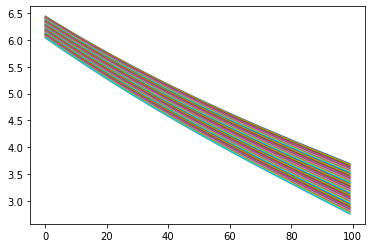

In [5]:
plt.plot(ϕ_i[0])

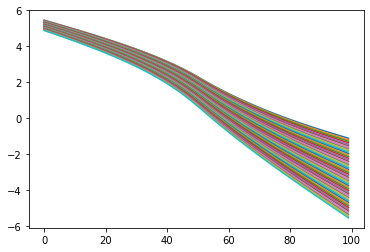

In [6]:
plt.plot(ϕ_i[1])

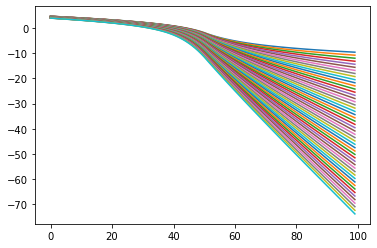

In [7]:
plt.plot(ϕ_i[2])

In [8]:
def false_transient_robust(y1_grid, y2_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000, print_all=True):
    η, δ, θ, γ_1, γ_2, πc_o, πd_o, ξ_a, ξ_p, ϕ_i = model_paras
    dy1 = y1_grid[1] - y1_grid[0]
    dy2 = y2_grid[1] - y2_grid[0]
    (y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
    stateSpace = np.hstack([y1_mat.reshape(-1, 1, order='F'), y2_mat.reshape(-1, 1, order='F')])    

    if v0 is None:
        v0 = -η*(y1_mat+y2_mat+(y1_mat+y2_mat)**2)

    d_Λ = γ_1 + γ_2*y1_mat

    πd = np.ones((len(πd_o), len(y1_grid), len(y2_grid)))
    for i in range(πd.shape[0]):
        πd[i] = πd_o[i]
    πd_o = πd

    πc = np.ones((len(πc_o), len(y1_grid), len(y2_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape

    bc_y = -ξ_p*np.log(np.sum(πd_o[:, -1, :]*np.exp(-1./ξ_p*ϕ_i[:, -1, :]), axis=0))
    bc = (np.zeros(0), bc_y, np.zeros(0), np.zeros(0))
    impose_bc = (False, True, False, False)

    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()

        v0_dy1 = compute_derivatives(v0, 0, 1, dy1)
        v0_dy2 = compute_derivatives(v0, 1, 1, dy2)        

        e_tilde = -η/(v0_dy2*λ*np.sum(πc_o*θ, axis=0))
        e_tilde[e_tilde<=0] = 1e-15

        log_πc_ratio = -v0_dy2*λ*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

        A = np.ones_like(y1_mat) * (-δ)
        B1 = y2_mat
        B2 = λ*(-y2_mat+np.sum(πc_o*θ, axis=0)*e_tilde)
        C1 = np.zeros_like(y1_mat)
        C2 = np.zeros_like(y2_mat)
        D = η*np.log(e_tilde) + (η-1)/δ*d_Λ*y2_mat + ξ_a * c_entropy

        v0 = false_transient_one_iteration_python(A, B1, B2, C1, C2, D, v0, ϵ, dy1, dy2, bc, impose_bc) # CG tol = 1e-10

        rhs_error = A*v0 + B1*v0_dy1 + B2*v0_dy2 + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    res = {'v0': v0,
           'e_tilde': e_tilde}
    return res

In [9]:
nbar = int(y_bar/y1_step) + 1
ϕ_i_short = np.array([temp[:nbar, :] for temp in ϕ_i])
model_paras = (η, δ, θ, γ_1, γ_2, πc_o, πd_o, ξ_a, ξ_p, ϕ_i_short)
model_res = false_transient_robust(y1_grid_short, y2_grid, model_paras,
                                   v0=np.average(ϕ_i_short, weights=πd_o, axis=0),
                                   ϵ=1., tol=1e-7, max_iter=1000, print_all=True)

Iteration 1: LHS Error: 4.426644350565743; RHS Error 0.06419615112518975
Iteration 2: LHS Error: 0.9139217153711225; RHS Error 1.8328446879027196
Iteration 3: LHS Error: 0.5705437318737299; RHS Error 0.7132905867576099
Iteration 4: LHS Error: 0.3981254704078663; RHS Error 0.39910302659464764
Iteration 5: LHS Error: 0.29280624441330816; RHS Error 0.24444793568068857
Iteration 6: LHS Error: 0.22206116181885793; RHS Error 0.15321236889940093
Iteration 7: LHS Error: 0.17365035600802603; RHS Error 0.10758241428940596
Iteration 8: LHS Error: 0.14090932668744682; RHS Error 0.12816026166029382
Iteration 9: LHS Error: 0.11462877605464333; RHS Error 0.13829102758158746
Iteration 10: LHS Error: 0.09595944869756168; RHS Error 0.14339974188321175
Iteration 11: LHS Error: 0.0809182064814448; RHS Error 0.14607357143124014
Iteration 12: LHS Error: 0.06941582907912819; RHS Error 0.14753216033458588
Iteration 13: LHS Error: 0.0599811386582732; RHS Error 0.14843507821206153
Iteration 14: LHS Error: 0.052

Iteration 112: LHS Error: 0.006224576353484057; RHS Error 0.14977699015679163
Iteration 113: LHS Error: 0.006150484879155815; RHS Error 0.14981073441413284
Iteration 114: LHS Error: 0.0060713984267306564; RHS Error 0.14982742043553635
Iteration 115: LHS Error: 0.005999933071257679; RHS Error 0.1498488860241376
Iteration 116: LHS Error: 0.005929912551235983; RHS Error 0.14984604828115472
Iteration 117: LHS Error: 0.005855176531523121; RHS Error 0.14978412688017512
Iteration 118: LHS Error: 0.00578525716092626; RHS Error 0.14981552911650942
Iteration 119: LHS Error: 0.005718579122257594; RHS Error 0.1497974489573523
Iteration 120: LHS Error: 0.005647443986241729; RHS Error 0.14982427356406902
Iteration 121: LHS Error: 0.005580009782660156; RHS Error 0.1498457691988242
Iteration 122: LHS Error: 0.005516075019506239; RHS Error 0.14981748058945646
Iteration 123: LHS Error: 0.005447916217441229; RHS Error 0.14978762765161224
Iteration 124: LHS Error: 0.005383623019281192; RHS Error 0.1497951

Iteration 221: LHS Error: 0.0008503787459765988; RHS Error 0.149812994777656
Iteration 222: LHS Error: 0.0008078272909877171; RHS Error 0.1498128763609495
Iteration 223: LHS Error: 0.0007666437535975845; RHS Error 0.14981241068029644
Iteration 224: LHS Error: 0.0007268488866927214; RHS Error 0.1498123493399054
Iteration 225: LHS Error: 0.0006884568622629317; RHS Error 0.14981193734765702
Iteration 226: LHS Error: 0.0006514757420568174; RHS Error 0.1498116725287698
Iteration 227: LHS Error: 0.0006159077377869693; RHS Error 0.14981128350629835
Iteration 228: LHS Error: 0.0005817496705704528; RHS Error 0.14981099286134164
Iteration 229: LHS Error: 0.0005489931436732931; RHS Error 0.14981065504850427
Iteration 230: LHS Error: 0.000517625121623233; RHS Error 0.14981033168397306
Iteration 231: LHS Error: 0.00048762800070800694; RHS Error 0.14981020671599882
Iteration 232: LHS Error: 0.00045897432299124574; RHS Error 0.1498108317855024
Iteration 233: LHS Error: 0.00043165444757953253; RHS Err

Iteration 325: LHS Error: 0.00012259046153273445; RHS Error 0.14981216764640795
Iteration 326: LHS Error: 0.00012451341587382814; RHS Error 0.14978491206698571
Iteration 327: LHS Error: 0.0001241144230110791; RHS Error 0.14981224266652376
Iteration 328: LHS Error: 0.00012195131849290775; RHS Error 0.14978474389705626
Iteration 329: LHS Error: 0.00012242111242422027; RHS Error 0.14981216971263187
Iteration 330: LHS Error: 0.0001243223292202167; RHS Error 0.14978489885525464
Iteration 331: LHS Error: 0.00012390022744179774; RHS Error 0.14981224782280028
Iteration 332: LHS Error: 0.0001219172450857009; RHS Error 0.14978478975432366
Iteration 333: LHS Error: 0.000122332968874872; RHS Error 0.14981218738435859
Iteration 334: LHS Error: 0.00012447041120244862; RHS Error 0.14978493296406453
Iteration 335: LHS Error: 0.00012402717256687623; RHS Error 0.14981226191394298
Iteration 336: LHS Error: 0.00012195481824583965; RHS Error 0.14978476744635402
Iteration 337: LHS Error: 0.00012235915920122

Iteration 432: LHS Error: 0.00012389807261747876; RHS Error 0.14978473089564323
Iteration 433: LHS Error: 0.00012381829577146064; RHS Error 0.14981215961374272
Iteration 434: LHS Error: 0.00012342550609734104; RHS Error 0.14978467688528063
Iteration 435: LHS Error: 0.00012348848515886246; RHS Error 0.1498121245674713
Iteration 436: LHS Error: 0.00012405571920615088; RHS Error 0.14978472798569492
Iteration 437: LHS Error: 0.00012389289726444375; RHS Error 0.14981214017645794
Iteration 438: LHS Error: 0.0001236207022929925; RHS Error 0.14978471660742482
Iteration 439: LHS Error: 0.00012368834843057286; RHS Error 0.1498121364582655
Iteration 440: LHS Error: 0.00012372962184059588; RHS Error 0.1497847026087375
Iteration 441: LHS Error: 0.00012372908570057461; RHS Error 0.14981214341028837
Iteration 442: LHS Error: 0.00012302167162570044; RHS Error 0.14978474715230616
Iteration 443: LHS Error: 0.00012315142134600165; RHS Error 0.1498121576580641
Iteration 444: LHS Error: 0.00012409122541745

Iteration 536: LHS Error: 0.0001244447428705442; RHS Error 0.14978476337495095
Iteration 537: LHS Error: 0.00012416694471761858; RHS Error 0.14981216781530438
Iteration 538: LHS Error: 0.0001225293243307668; RHS Error 0.1497846862475899
Iteration 539: LHS Error: 0.00012290460143260518; RHS Error 0.14981213522542808
Iteration 540: LHS Error: 0.00012437279625165942; RHS Error 0.14978481200770688
Iteration 541: LHS Error: 0.0001240271917724023; RHS Error 0.14981219233477477
Iteration 542: LHS Error: 0.00012251831515630585; RHS Error 0.14978472164664913
Iteration 543: LHS Error: 0.0001228415166907304; RHS Error 0.14981215155040228
Iteration 544: LHS Error: 0.00012430856114864497; RHS Error 0.14978484709123469
Iteration 545: LHS Error: 0.00012404530853604712; RHS Error 0.14981221132979866
Iteration 546: LHS Error: 0.00012283071262020329; RHS Error 0.14978470903181262
Iteration 547: LHS Error: 0.0001229990564612926; RHS Error 0.14981213143408517
Iteration 548: LHS Error: 0.000124353385023034

Iteration 641: LHS Error: 0.00012316685263380478; RHS Error 0.149812166646159
Iteration 642: LHS Error: 0.0001239602584770516; RHS Error 0.14978480426888166
Iteration 643: LHS Error: 0.00012387400534130677; RHS Error 0.14981220110376955
Iteration 644: LHS Error: 0.00012270359594701574; RHS Error 0.1497846835745257
Iteration 645: LHS Error: 0.00012294505270515899; RHS Error 0.1498121406822407
Iteration 646: LHS Error: 0.00012420904137533384; RHS Error 0.14978479581746024
Iteration 647: LHS Error: 0.0001239097719891724; RHS Error 0.1498121802609342
Iteration 648: LHS Error: 0.00012327841811421436; RHS Error 0.1497847127320554
Iteration 649: LHS Error: 0.00012344737773961612; RHS Error 0.14981214169317872
Iteration 650: LHS Error: 0.0001240428915192382; RHS Error 0.1497847542249342
Iteration 651: LHS Error: 0.00012394511472191283; RHS Error 0.14981216178061163
Iteration 652: LHS Error: 0.00012351986146441618; RHS Error 0.1497846644127429
Iteration 653: LHS Error: 0.0001235156527545911; RH

Iteration 745: LHS Error: 0.0001231157889480805; RHS Error 0.1498122017917537
Iteration 746: LHS Error: 0.00012336563002302015; RHS Error 0.14978485178224277
Iteration 747: LHS Error: 0.0001233972992080723; RHS Error 0.14981222776662406
Iteration 748: LHS Error: 0.00012309384006625734; RHS Error 0.1497847856134124
Iteration 749: LHS Error: 0.00012313316698175925; RHS Error 0.14981217851188844
Iteration 750: LHS Error: 0.00012418857487661583; RHS Error 0.1497848075919483
Iteration 751: LHS Error: 0.00012391749352547166; RHS Error 0.14981218525432477
Iteration 752: LHS Error: 0.00012272387922029893; RHS Error 0.14978474322041802
Iteration 753: LHS Error: 0.00012298229110552228; RHS Error 0.14981216662747404
Iteration 754: LHS Error: 0.0001235569293873695; RHS Error 0.14978485304409633
Iteration 755: LHS Error: 0.0001234736121658031; RHS Error 0.1498122238353181
Iteration 756: LHS Error: 0.00012280170820400116; RHS Error 0.14978476870718246
Iteration 757: LHS Error: 0.0001229097125192702;

Iteration 853: LHS Error: 0.00012398487414699844; RHS Error 0.1498121791315173
Iteration 854: LHS Error: 0.00012244800288474522; RHS Error 0.1497847566079366
Iteration 855: LHS Error: 0.0001228051547399467; RHS Error 0.14981217207937025
Iteration 856: LHS Error: 0.0001239201702203374; RHS Error 0.14978485714354622
Iteration 857: LHS Error: 0.0001237466488639427; RHS Error 0.14981222907084538
Iteration 858: LHS Error: 0.00012257985974484242; RHS Error 0.14978474715953874
Iteration 859: LHS Error: 0.00012279078792643006; RHS Error 0.14981215833976796
Iteration 860: LHS Error: 0.00012458674177961981; RHS Error 0.14978484046317941
Iteration 861: LHS Error: 0.00012423752174450797; RHS Error 0.14981220579618942
Iteration 862: LHS Error: 0.00012259153314486682; RHS Error 0.1497846689701949
Iteration 863: LHS Error: 0.00012292074285547017; RHS Error 0.1498121291137784
Iteration 864: LHS Error: 0.00012415641259533317; RHS Error 0.1497848187381084
Iteration 865: LHS Error: 0.0001238860966177313;

Iteration 958: LHS Error: 0.00012307039542802656; RHS Error 0.14978468816904078
Iteration 959: LHS Error: 0.00012319440620034428; RHS Error 0.14981213084875866
Iteration 960: LHS Error: 0.00012364585979263154; RHS Error 0.14978480581695347
Iteration 961: LHS Error: 0.0001235699280068836; RHS Error 0.14981220096058023
Iteration 962: LHS Error: 0.00012240127853369032; RHS Error 0.14978478535799153
Iteration 963: LHS Error: 0.0001226686259490073; RHS Error 0.14981219701529996
Iteration 964: LHS Error: 0.00012375473905246182; RHS Error 0.14978489042128904
Iteration 965: LHS Error: 0.0001235368819192395; RHS Error 0.1498122328853992
Iteration 966: LHS Error: 0.0001232366412371455; RHS Error 0.1497847762433771
Iteration 967: LHS Error: 0.00012330378985048185; RHS Error 0.14981218191769194
Iteration 968: LHS Error: 0.00012355196232372023; RHS Error 0.14978476411688202
Iteration 969: LHS Error: 0.00012345898896759522; RHS Error 0.1498121790933019
Iteration 970: LHS Error: 0.0001229879504194286

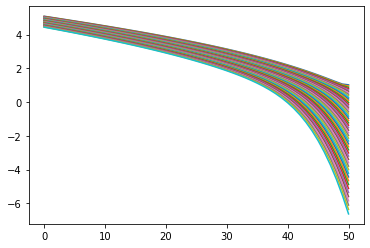

In [10]:
plt.plot(model_res['v0'])